### Random Forests (Bosques aleatorios)

#### Introducción

Para solucionar el problema de clasificadores débiles correlacionados entre sí, Breiman
(2001) diseñó los Random Forests. Éstos se pueden entender como una extensión de un
ensamble Bagging. De manera similar a éstos, se genera un conjunto finito de submuestras
con reemplazo mediante Bootstrap. Para resolver el problema de correlación entre
clasificadores, se incluye un mecanismo aleatorio de selección de atributos. Durante la
construcción de árboles, Random Forests selecciona un subconjunto de atributos de manera
aleatoria y prosigue de igual manera con el entrenamiento y selección de particiones. Dado
que con bagging contamos todos los atributos en cada árbol, Random Forest agrega más
aleatoriedad en el proceso de crecimiento de los árboles.

Los Random Forests dependen de un parámetro K que controla la incorporación de
aleatoriedad. Cuando 𝐾 = #𝐴𝑡𝑟𝑖𝑏𝑢𝑡𝑜𝑠 el árbol construido es idéntico a un proceso
determinístico. Cuando K=1, el árbol construido tendrá un atributo escogido al azar. Breiman
(2001) sugiere que un buen valor es 𝐾 = 𝑙𝑜𝑔(#𝐴𝑡𝑟𝑖𝑏𝑢𝑡𝑜𝑠).

Cabe señalar que la aleatorización se induce en la selección de atributos, no en la selección
de divisiones para el conjunto de atributos.
Tienen un peor punto de inicio aleatorio, pero converge a tasas de error bajas en menor
cantidad de iteraciones, en comparación a otros modelos. En la etapa de entrenamiento es
más eficiente que un ensamble Bagging, dado que implementa árboles aleatorios que
necesitan sólo del subconjunto de atributos en oposición a Bagging donde se deben incluir
todos.

##### Pasos para construir un Random Forest

![Random Forest](fotos/Random_forest.jpg)

1. Fijar la cantidad de árboles a construir.
2. Para cada árbol a construir:
    - Generamos una muestra con bootstrap.
    - Hacemos crecer un árbol en ésta.
    - Para cada split existente:
        - Seleccionamos j variables de manera aleatoria de 𝐽.
        - Seleccionamos el mejor punto de corte entre las variables j.
        - Particionamos el nodo en dos.

##### Digresión: La receta para cocinar un buen ensemble

Al igual que hoy en día pasa con los modelos basados en redes neuronales, mucho esfuerzo
se puso en algún momento en el desarrollo de métodos de ensamblado ya que aportaron un
gran salto en efectividad a partir de los modelos clásicos. Random Forest no es el único
método de ensamblado ni mucho menos el "mejor", existen otros modelos que pueden
llegar a presentar tanta o mejor efectividad que RF, pero, ¿En qué se diferencian todos estos
métodos entre sí?, para responder esta pregunta, veamos en qué se parecen.

Como mencionamos, un método de ensamblado combina una serie de máquinas para
conformar una sola máquina: $𝐹 = \sum^{N}_{i} W_i \times f_1$.

F es el ensamble, 𝑓 es el Learner Base: la máquina básica con la cual se construye el
ensamble, en el caso de RF el learner base es un árbol de clasificación. Por otro lado, 𝑤
representa la "importancia" que se le dará a una determinada máquina 𝐹 dentro del contexto
del ensemble.

Bajo esta definición podemos juntar cualquier conjunto de máquinas que nos gusten y
armar un gran monstruo de Frankenstein. Lamentablemente esta aproximación no nos
asegura obtener un buen ensemble, la clave de la receta está en inyectar diversidad.
Podemos inyectar diversidad de diversas formas (pun intended), para esto se puede variar el
learner base, manipular directamente los datos (distintos conjuntos de entrenamiento) o
incluso variar los hiper parámetros.

En el proceso de manipular los datos, podemos particionar horizontalmente o verticalmente
(feature selection). RF implementa ambas, particiona horizontalmente al utilizar distintas
muestras bootstrap para entrenar los distintos learner base y al mismo tiempo particiona
verticalmente implementando la selección aleatoria de atributos con los que se entrenará a
cada learner base.

#### Out-Of-Bag

Con los modelos anteriores, estábamos acostumbrados a implementar validación cruzada
para escoger de mejor manera los hiper parámetros y mejorar nuestra capacidad predictiva.
El problema con Bagging y Random Forest es que implementar la validación cruzada puede
ser bastante costoso en términos computacionales. Dado que en cada paso de validación
cruzada estamos construyendo 𝐾 × 𝑛_𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑜𝑟𝑠.

Una de las ventajas de los Random Forests es que devuelve un error "fuera de la bolsa".

Dado esta característica de los datos provista mediante bootstrap, la bondad de los
clasificadores se puede estimar a partir de estos datos ignorados en cada instancia del
modelo. Esto se conoce como la muestra out-of-bag (OOB, de aquí en adelante, y nos
permite generar una aproximación a la tasa de errores con validación cruzada.

Para cada observación $𝑧_i - (x_i - y_i)$ construir un predictor con random forest mediante el
promedio de aquellos árboles con muestras de bootstrap en donde $𝑧_i$ no aparezca. Un error
estimado out-of-bag tendrá un comportamiento idéntico al obtenido con una validación
cruzada N fold. Esta es una ventaja de RF por sobre otros algoritmos, dado que se
implementa la validación cruzada en el mismo tiempo en que el modelo se ejecuta (Hastie
et al., 2009).

Para obtener el estimador OOB, necesitamos registrar los ejemplos de entrenamiento
implementados en cada instancia de clasificador débil. La predicción OOB de las
observaciones no entrenados con 𝑋 se obtiene a partir de:

$$ H^{out-of-bag} (X) = \dfrac{1}{|Datos|} \sum_{x,y \in Datos} I(H^{out-of-bag} (X \neq y))$$

Dado que cada árbol se construye a partir de una muestra realizada con bootstrap, para
cada árbol existe una porción de los datos no se utiliza con la cual podemos estimar qué tan
bueno es nuestra estimación.

### Implementación de Random Forest para la clasificación de votos

Para exponer la implementación de un algoritmo Random Forest, utilizaremos los datos en
el archivo voting.csv de la lectura de Árboles de Clasificación. Implementaremos el mismo
proceso de preprocesamiento y selección de atributos que cuando implementamos el
modelo DecisionTreeClassifier.

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lec8_graphs as afx

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
df = pd.read_csv('Datasets/voting.csv').drop(columns = 'Unnamed: 0')
df.sample(5, random_state = 15820)

,region,population,sex,age,education,income,statusquo,vote
769,C,175000,F,44.0,S,7500.0,-1.15622,U
1480,S,25000,F,31.0,P,7500.0,1.50986,Y
1523,S,125000,F,40.0,S,35000.0,0.43786,Y
471,C,250000,F,25.0,S,35000.0,-0.65599,N
2193,SA,250000,M,65.0,P,2500.0,1.54947,Y


In [4]:
# Vamos a binarizar cada variable categórica, ignorando la primera categoría de referencia
# Región del país
# Nivel educacional del encuestado
# Sexo del encuestado
# Intención de voto
# Botamos las variables originales
# Nos aseguramos de limpiar los datos perdidos
# generamos las muestras definiendo la matriz de atributos
# el vector objetivo
# el tamaño de la muestra a dejar como validación
# definiendo la semilla pseudoaleatoria
df = pd.concat([df, pd.get_dummies(df['region'], drop_first = True, prefix = 'region')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['education'], drop_first = True, prefix = 'ed')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['sex'], drop_first = True, prefix = 'sex')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['vote'], drop_first = False, prefix = 'vote')], axis = 1)
df = df.drop(columns=['region', 'sex', 'education', 'vote'])
df.head()

,population,age,income,statusquo,region_M,region_N,region_S,region_SA,ed_PS,ed_S,sex_M,vote_A,vote_N,vote_U,vote_Y
0,175000,65.0,35000.0,1.00820,0,1,0,0,0,0,1,0,0,0,1
1,175000,29.0,7500.0,-1.29617,0,1,0,0,1,0,1,0,1,0,0
2,175000,38.0,15000.0,1.23072,0,1,0,0,0,0,0,0,0,0,1
3,175000,49.0,35000.0,-1.03163,0,1,0,0,0,0,0,0,1,0,0
4,175000,23.0,35000.0,-1.10496,0,1,0,0,0,1,0,0,1,0,0


In [5]:
df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'population':'ed_S'], 
                                                    df['vote_N'], test_size = .33, random_state = 15820)

Para implementar un Random Forest para un problema de clasificación, debemos incorporar
la clase sklearn.ensemble.RandomForestClassifier.

##### Digresión: Implementación de Random Forest
Resulta que la implementación original de Random Forest diseñada por Breiman (2001)
dista de la implementación en scikit-learn. En la implementación de Breiman, cada
clasificador debe votar por una clase específica. Mientras que la implementación de
scikit-learn promedia la predicción probabilística de cada clasificador antes de asignar
la clase.

La implementación similar a Breiman en scikit-learn corresponde a VotingClassifier.

Anteriormente hablamos de las virtudes de la muestra out-of-bag. Para solicitarla en nuestro
ensamble de Random Forest, necesitamos declarar la opción oob_score=True, que
permitirá registrar el efecto predictivo de cada modelo dentro del ensamble en la muestra
que no fue incluida dentro del bootstrap.

In [7]:
voting_rf = RandomForestClassifier(oob_score = True, random_state = 15820).fit(X_train, y_train)

Si implementamos el modelo con la cantidad por defecto de estimadores
(n_estimators=10), sklearn advertirá que algunos modelos no tienen puntajes OOB dado
que existen muy pocos árboles como para estimar OOB de forma confiable.

Probablemente dado el desbalance entre clases de nuestro vector objetivo, el modelo tiene
un peor desempeño en identificar correctamente aquellos casos donde se votó que no.

In [16]:
len(voting_rf.estimators_)

100

In [8]:
print(classification_report(y_test, voting_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       575
           1       0.75      0.72      0.74       280

    accuracy                           0.83       855
   macro avg       0.81      0.80      0.81       855
weighted avg       0.83      0.83      0.83       855



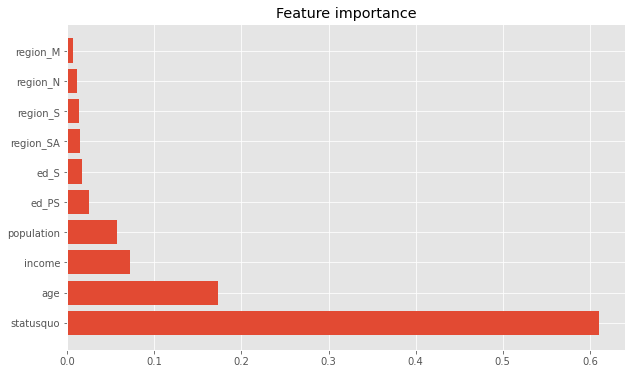

In [10]:
voting_rf.feature_importances_
x_mat_vars = df.loc[:, 'population':'ed_S']
afx.plot_importance(voting_rf, x_mat_vars.columns)


Visualizando el efecto de múltiples árboles en la clasificación
Refinemos el modelo mediante la separación de los dos atributos con una mayor
importancia relativa en la definición de cortes. Estos son statusquo y age. Al visualizar las
observaciones condicional al vector objetivo, encontramos que aquellos que votaría no en el
Plebiscito se posicionan en valores negativos, mientras que el efecto de la edad parece ser
constante. Existe una superposición entre observaciones que impide el buen
funcionamiento de un clasificador lineal.

Text(0.5, 0, 'Age')

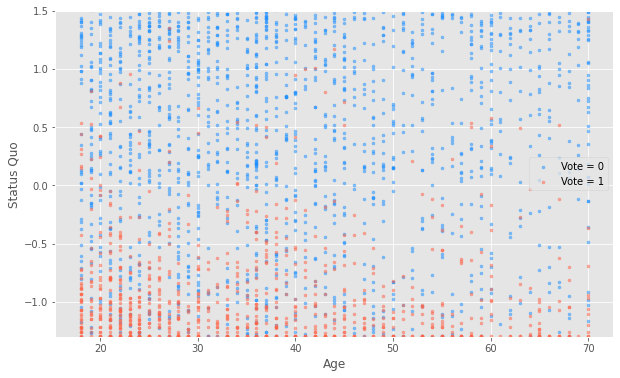

In [11]:
depured_X = df.loc[:, ['age', 'statusquo', 'vote_N']]
colors = ['dodgerblue', 'tomato']

for i in depured_X['vote_N'].unique():
    plt.scatter(depured_X[depured_X['vote_N'] == i]['age'],
        depured_X[depured_X['vote_N'] == i]['statusquo'], 
        marker = '.', label = "Vote = {}".format(i), alpha = .5, color = colors[i])
        
plt.legend()
plt.ylim(-1.3, 1.5)
plt.ylabel('Status Quo')
plt.xlabel('Age')

Para efectos prácticos, entrenaremos un Random Forest con 500 árboles en la muestra
completa, de manera tal de ver cómo se comporta el clasificador.

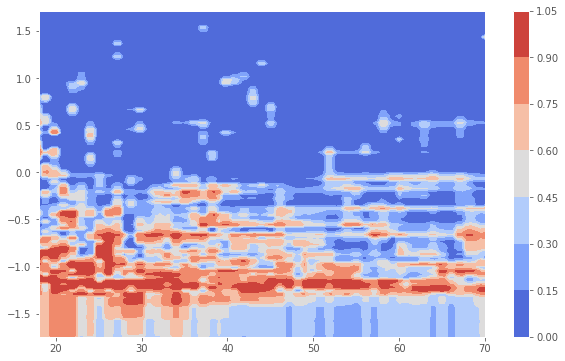

In [12]:
random_forest = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 15820, 
                                    oob_score = True).fit(depured_X.loc[:, 'age':'statusquo'], depured_X['vote_N'])

get_x_1 = afx.fetch_lims(depured_X['statusquo'])
get_x_2 = afx.fetch_lims(depured_X['age'])

x_mesh, y_mesh, joint_xy = afx.generate_mesh_grid(depured_X, 'age', 'statusquo')
Z = random_forest.predict_proba(np.c_[x_mesh.ravel(), y_mesh.ravel()])[:, 1].reshape(x_mesh.shape)

plt.contourf(x_mesh, y_mesh, Z, cmap = 'coolwarm')
plt.colorbar()

La superficie de respuesta inferida en el modelo mapea de forma eficiente la probabilidad de
votar No, permitiendo separar aquellas observaciones que se escapan de la norma.

#### Incorporación de aleatoriedad en los atributos

Anteriormente se mencionó una de las principales características sobre los Random Forest:
la capacidad de inducir aleatoriedad en la cantidad de atributos agregados. En la clase
sklearn.ensemble.RandomForestClassifier, el hiper parámetro se controla con la
opción max_features. Las opciones disponibles son:
- Un número entero que fija la cantidad de atributos en cada estimador.
- Un número flotante que considera una fracción de los atributos mediante
  int(max_features * n_features).
- auto y sqrt conllevan a la misma estrategia, donde la cantidad de atributos se
escoge con 𝑛_𝑎𝑡𝑟𝑖𝑏𝑢𝑡𝑜𝑠. Esta es la opción por defecto.
- log2, la cantidad de atributos se escoge con 𝑙𝑜𝑔2.
 (𝑛_𝑎𝑡𝑟𝑖𝑏𝑢𝑡𝑜𝑠)
- None, la cantidad de atributos máximos corresponde a la cantidad de atributos total
  en la matriz. Esta situación es idéntica a un algoritmo de ensamble Bagging.

Breiman (2001) sugiere que un buen valor por defecto para escoger la cantidad de atributos
a aleatorizar es mediante el logaritmo. Para ejemplificar el efecto de la aleatorización de los
atributos en los modelos, evaluaremos el desempeño de cada criterio de selección
condicional a una serie de estimadores. El código presentado abajo registrará los puntajes
OOB y exactitud (medidos como el error, siguiendo las prácticas de Hastie et al. (2009)).

In [13]:
# generamos una serie de listas para guardar los valores
tmp_oob_none, tmp_oob_sqrt,tmp_oob_log2 = [], [], []
tmp_test_acc_none, tmp_test_acc_sqrt, tmp_test_acc_log = [], [], []
n_estimators = range(20, 1000, 25)

In [14]:
# para cada rango de modelos estimados
for i in n_estimators:
    
    # Implementamos una variante con todos los atributos
    voting_rf_none = RandomForestClassifier(n_estimators = i, max_features = None, oob_score = True, 
                                            random_state = 158).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con sqrt
    voting_rf_sqrt = RandomForestClassifier(n_estimators= i, max_features = "sqrt", warm_start = True, 
                                            oob_score = True, random_state = 158).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con log
    voting_rf_log = RandomForestClassifier(n_estimators = i, max_features = "log2", warm_start = True, 
                                            oob_score = True, random_state=158).fit(X_train, y_train)

    # Estimamos el error en OOB
    tmp_oob_none.append(1 - voting_rf_none.oob_score_)
    tmp_oob_sqrt.append(1 - voting_rf_sqrt.oob_score_)
    tmp_oob_log2.append(1 - voting_rf_log.oob_score_)

    # Estimamos el error en la exactitud
    tmp_test_acc_none.append(1 - accuracy_score(y_test, voting_rf_none.predict(X_test)))
    tmp_test_acc_sqrt.append(1 - accuracy_score(y_test, voting_rf_sqrt.predict(X_test)))
    tmp_test_acc_log.append(1 - accuracy_score(y_test, voting_rf_log.predict(X_test)))

El primer punto a destacar en la figura, es que el no aleatorizar los atributos en cada modelo
del ensamble genera un peor desempeño tanto en puntaje OOB y error en la muestra de
validación. El segundo punto a considerar es que para este problema el desempeño es
idéntico al implementar un criterio de aleatorización de atributos log o sqrt. Un tercer
elemento a considerar es el hecho que el comportamiento del puntaje OOB tiende a mejorar
en la medida que aumentamos la cantidad de estimadores a incluir en el ensamble.

<Figure size 864x288 with 0 Axes>

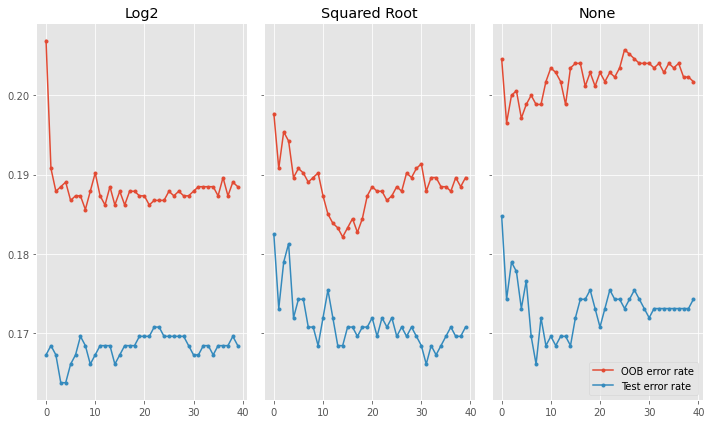

In [15]:
plt.figure(figsize=(12, 4))
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].plot(tmp_oob_log2, '.-', label='OOB error rate')
axs[0].plot(tmp_test_acc_log, '.-', label='Test error rate')
axs[0].set_title('Log2')
axs[1].plot(tmp_oob_sqrt,'.-', label='OOB error rate')
axs[1].plot(tmp_test_acc_sqrt,'.-', label='Test error rate')
axs[1].set_title('Squared Root')
axs[2].plot(tmp_oob_none, '.-', label='OOB error rate')
axs[2].plot(tmp_test_acc_none,'.-', label='Test error rate')
axs[2].set_title('None')
plt.tight_layout()
plt.legend()

#### Aspectos adicionales a considerar

##### Pros

- Si bien Bagging se considera un punto procedimental para entender el
  comportamiento de Random Forests, las clases
  sklearn.ensemble.BaggingRegressor y
  sklearn.ensemble.BaggingClassifier funcionan como wrappers: métodos que
  nos permiten flexibilizar los modelos a ingresar.
- Por lo general estos modelos tienen un buen desempeño "out-of-the-box", dado que
  no hay mucho hiper parámetro a modificar que afecte a la forma funcional del
  modelo (a diferencia de Support Vector MachineS). Todos los hiper parámetros
  tienen propiedades asintóticas.
- Dado que se itera una serie de veces, tienen un método de validación cruzada sin la
  necesidad de envolverlo en un sklearn.model_selection.GridSearchCV.
- Como se basan en árboles, no es necesario preprocesamiento alguno y son robustos
  a casos atípicos.

##### Cons

- Random Forest tiene una baja interpretabilidad, ofuscada por la selección de
  atributos aleatorizada.
- Tiene una complejidad sustancial dependiendo de la cantidad de datos.

#### Referencias
- Breiman, Leo. 2001. Random Forests.
- Zhou, 2012. Ensembles Methods. Foundations and Algorithms.
- Hastie, T; Tibshirani, R; Friedman, J. 2009. The Elements of Statistical Learning.
- Kearns y Valliant. 1989. Cryptographic limitations on Learning Boolean Formulae and
  Finite Automata.
